## Quintero's Analogies (2021)

In [11]:
# Importing libraries.
import pandas as pd
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import os

# Loading the dataset.
analogies_df = pd.read_csv('all_answers_rank_1.csv')
analogies_df.head()

,Unnamed: 0,cueExample,targetExample,cue,response,count,rank,p
0,1,abogado,corte,doctor,hospital,58,1,0.651685
1,2,amigos,felicidad,jefe,trabajo,15,1,0.159574
2,3,árbol,hojas,flor,pétalos,67,1,0.644231
3,4,Argentina,Buenos_Aires,Brasil,Brasilia,87,1,0.906250
4,5,ave,ala,delfín,aleta,79,1,0.858696


In [15]:
embeddings_WIKI = KeyedVectors.load_word2vec_format('embeddings/wiki.es.vec', limit=None)
embeddings_SUC = KeyedVectors.load_word2vec_format('embeddings/embeddings-l-model.vec', limit=None)
embeddings_SWOW = KeyedVectors.load_word2vec_format('embeddings/swow.embedding.was.26-04-2022.vec', limit=None)
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
embeddings_SBWC = KeyedVectors.load_word2vec_format('embeddings/SBW-vectors-300-min5.txt', limit=None)
embeddings_Glove = KeyedVectors.load_word2vec_format('embeddings/glove-sbwc.i25.vec', limit=None)

In [16]:
# SWOW embedding converted to lowercase

# SWOW vectors and words.
words = list(embeddings_SWOW.key_to_index.keys())
vectors = list(embeddings_SWOW.vectors)

# Convert all words to lowercase.
lowercase_words = [word.lower() for word in words]

# Creating a new SWOW model with lowercase words and vectors.
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
lower_embeddings_SWOW.add_vectors(lowercase_words, vectors)

In [17]:
embeddings_list = [embeddings_WIKI, embeddings_SUC, lower_embeddings_SWOW, embeddings_SBWC, embeddings_Glove]

In [18]:
# Calculate the frequency of 'cue' and 'response' combinations and their ranks to identify the most relevant analogies.
analogies_df['count'] = analogies_df.groupby(['cue','response'])['response'].transform('count')
analogies_df['rank'] = analogies_df.groupby('cue')['count'].rank(ascending=False, method='min')

# Calculate the frequency percentage of each combination relative to the total number of responses for that 'cue'.
total_responses = analogies_df.groupby('cue')['response'].transform('count')
analogies_df['percentage'] = (analogies_df['count'] / total_responses) * 100

# Indices of rows with minimum rank (rank 1).
idx = analogies_df.groupby(['cue'])['rank'].idxmin()

# Keep only the rows with the most relevant combinations according to the rank.
analogies_df = analogies_df.loc[idx]

# Save the modified DataFrame to a CSV file.
analogies_df.to_csv('analogies_answers.csv', index=False)

# Convert all words to lowercase.
analogies_df['cueExample'] = analogies_df['cueExample'].apply(lambda x: str(x).lower())
analogies_df['targetExample'] = analogies_df['targetExample'].apply(lambda x: str(x).lower())
analogies_df['cue'] = analogies_df['cue'].apply(lambda x: str(x).lower())

# Perform the necessary replacements.
analogies_df['cueExample'] = analogies_df['cueExample'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogies_df['targetExample'] = analogies_df['targetExample'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogies_df['cue'] = analogies_df['cue'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')

In [19]:
# Filter rows that have all words in all embeddings

# "all" combines the boolean values of word in e.key_to_index, for all embeddings e
# then, it forms a value for each row for each of the 4 columns
columns = ['cueExample', 'targetExample', 'cue', 'response']
filter = [[all(word in e.key_to_index for e in embeddings_list) for word in analogies_df[column]] for column in columns]
# Keep only the rows that have all words in all embeddings
filter = [a & b & c & d for a, b, c, d in zip(filter[0], filter[1], filter[2], filter[3])]

analogies_df = analogies_df[filter]

#### Calculate predictions for K=25

In [30]:
from functions import topK_metrics, calculate_predictions

fixed_K = 25
all_predictions = [calculate_predictions(e, analogies_df, fixed_K) for e in embeddings_list]
# It is a list of lists, each list in all_predictions contains the predictions generated for each specific embedding
# Iterate over each embedding model (e) in embeddings_list and call the calcular_predicciones function with that model, the analogies_df, and the fixed_K value
# Generate predictions for each row in analogies_df using the embedding

#### Then calculate several K values by simply trimming the predictions list
#### trimming = recortando

In [31]:
### Then calculate several K values by simply trimming the predictions list

# Based on a single calculation of predictions, calculate metrics for different K values
Ks = [5, 10, 15, 20, 25]
topK_metrics = [[topK_metrics(prediction, analogies_df, K) for K in Ks] for prediction in all_predictions]
# List that stores the metrics calculated by metricas_topK for each set of predictions in all_predictions
# Iterate over each set of predictions in all_predictions and call the metricas_topK function with that set of predictions and the analogies_df
# Calculate the top-K precision metric for each set of predictions and return a list of these metrics, each value representing the top-K precision for a specific embedding model
print(f"Top-K metrics for Ks={Ks}: {topK_metrics}")

Top-K metrics for Ks=[5, 10, 15, 20, 25]: [[0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.03773584905660377, 0.05660377358490566], [0.03773584905660377, 0.07547169811320754, 0.09433962264150944, 0.11320754716981132, 0.1320754716981132], [0.05660377358490566, 0.1320754716981132, 0.1509433962264151, 0.24528301886792453, 0.3018867924528302], [0.05660377358490566, 0.07547169811320754, 0.09433962264150944, 0.09433962264150944, 0.11320754716981132], [0.09433962264150944, 0.18867924528301888, 0.22641509433962265, 0.2641509433962264, 0.2641509433962264]]


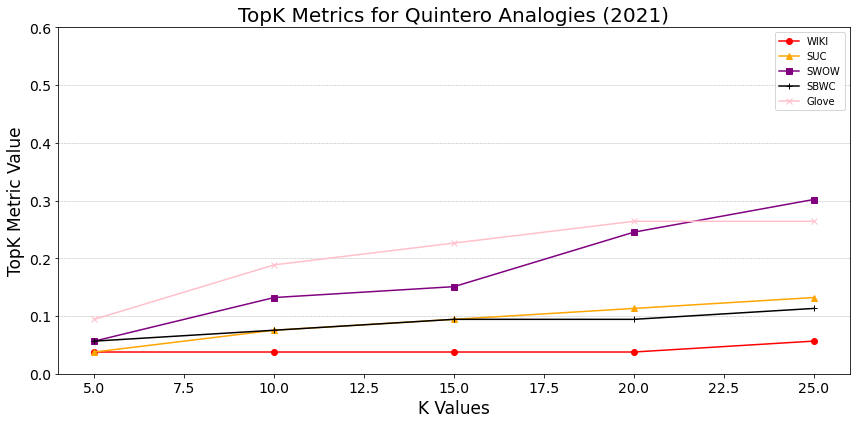

In [32]:
# Embedding names
embeddings_names = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# Colors for plotting
colors = ['red', 'orange', 'purple', 'black', 'pink']

# Markers to use
markers = ['o', '^', 's', '+', 'x']  # Markers for each category

# Number of embeddings
num_embeddings = len(embeddings_names)

# Create the figure for the fixed K value data
fig, ax = plt.subplots(figsize=(12, 6))

# x values for each bar
x = np.arange(num_embeddings)

# Plotting the data
for i, emb in enumerate(embeddings_names):
    plt.plot(Ks, topK_metrics[i], color=colors[i], label=embeddings_names[i], marker=markers[i])

# Labels
ax.set_xlabel('K Values', fontsize=17)
ax.set_ylabel('TopK Metric Value', fontsize=17)
ax.set_title('TopK Metrics for Quintero Analogies (2021)', fontsize=20)

# Limit the y-axis between 0 and 0.6
ax.set_ylim([0, 0.6])

ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.legend()
plt.show()

## Bigger Analogy Test Set (BATS)

In [34]:
# Load all files in a folder and convert them into DataFrames:
def load_files(folder):
    files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.txt')]
    dfs = {}
    for file in files:
        print(f'Reading file: {file}')
        with open(file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            # Create a DataFrame
            df_category = pd.DataFrame([line.strip().split() for line in lines], columns=['cue', 'response'])
            # Store the DataFrame in the dictionary
            file_name = os.path.basename(file)
            dfs[file_name] = df_category
    return dfs

# Folder where the subfolders of BATS grammatical categories are located (data/bats/categories)
data_folder = 'data'
bats_folder = os.path.join(data_folder, 'bats')

# Get the list of subfolders in the 'bats' folder (each one of the grammatical categories)
categories = [os.path.join(bats_folder, folder) for folder in os.listdir(bats_folder) if os.path.isdir(os.path.join(bats_folder, folder))]

# Initialize a dictionary to store the DataFrames of all categories
dfs_all_categories = {}

# Iterate over each category subfolder and load the files as DataFrames
for category in categories:
    category_name = os.path.basename(category)
    print(f'Loading files from category: {category_name}')
    dfs_all_categories[category_name] = load_files(category)

# dfs_all_categories is a dictionary containing the DataFrames of all grammatical categories

Loading files from category: derivational_morphology
Reading file: data\bats\derivational_morphology\[re+verb_reg].txt
Reading file: data\bats\derivational_morphology\[un+adj_reg].txt
Reading file: data\bats\derivational_morphology\[verb+able_reg].txt
Reading file: data\bats\derivational_morphology\[verb+er_irreg_femenino].txt
Reading file: data\bats\derivational_morphology\[verb+er_irreg_masculino].txt
Reading file: data\bats\derivational_morphology\[verb+ment_irreg].txt
Reading file: data\bats\derivational_morphology\[verb+tion_irreg].txt
Loading files from category: encyclopedic_semantics
Reading file: data\bats\encyclopedic_semantics\[animal - shelter].txt
Reading file: data\bats\encyclopedic_semantics\[animal - sound].txt
Reading file: data\bats\encyclopedic_semantics\[animal - young].txt
Reading file: data\bats\encyclopedic_semantics\[country - capital].txt
Reading file: data\bats\encyclopedic_semantics\[country - language].txt
Reading file: data\bats\encyclopedic_semantics\[male

### Derivational_morphology 

In [35]:
# Folder where the derivational_morphology subfolder is located
data_folder = 'data'
bats_folder = os.path.join(data_folder, 'bats')
derivational_folder = os.path.join(bats_folder, 'derivational_morphology')

# Load the files from the derivational_morphology folder as DataFrames
dfs_derivational_morphology = load_files(derivational_folder)

Reading file: data\bats\derivational_morphology\[re+verb_reg].txt
Reading file: data\bats\derivational_morphology\[un+adj_reg].txt
Reading file: data\bats\derivational_morphology\[verb+able_reg].txt
Reading file: data\bats\derivational_morphology\[verb+er_irreg_femenino].txt
Reading file: data\bats\derivational_morphology\[verb+er_irreg_masculino].txt
Reading file: data\bats\derivational_morphology\[verb+ment_irreg].txt
Reading file: data\bats\derivational_morphology\[verb+tion_irreg].txt


In [36]:
# Function to calculate predictions
def calculate_bats_predictions(embedding, df, fixed_K):
    bats_predictions = []
    not_found_words = []
    for index, row in df.iterrows():
        cue = row['cue']
        try:
            result = embedding.most_similar(positive=[cue], topn=fixed_K)
            if result:
                bats_predictions.append([word for word, _ in result])
            else:
                bats_predictions.append([])
        except KeyError as e:
            print(f"One of the words is not in the embedding: {cue} - {e}")
            bats_predictions.append([])
            not_found_words.append(cue)
        except Exception as e:
            print(f"Error processing the word '{cue}' at index {index}: {e}")
            bats_predictions.append([])
    return bats_predictions, not_found_words

# Function to calculate top-K metrics
def calculate_topK_bats_metrics(bats_predictions, df, K):
    df['response'] = df['response'].fillna('').apply(lambda x: str(x).lower())  # Remove whitespace around the word
    topK_bats_metrics = []
    for i, prediction in enumerate(bats_predictions):
        human_response = df.iloc[i]['response']
        if prediction:
            topK_bats_metrics.append(int(human_response in prediction[0:K]))
        else:
            topK_bats_metrics.append(0)
    return np.mean(topK_bats_metrics)

fixed_K = 5
#Ks = [5, 10, 15, 20, 25]

# Dictionary to store the calculated metrics
metrics_results = {}
not_found_words_by_file = {}

# Iterate over each file in dfs_derivational_morphology
for file_name, df in dfs_derivational_morphology.items():
    print(f'Analyzing file: {file_name}')
    print(df.head())  # Display the first rows of the DataFrame to check its content
    all_bats_predictions = []
    global_not_found_words = []
    for embedding in embeddings_list:
        bats_predictions, not_found_words = calculate_bats_predictions(embedding, df, fixed_K)
        all_bats_predictions.append(bats_predictions)
        global_not_found_words.extend(not_found_words)
    
    topK_bats_metrics = [[calculate_topK_bats_metrics(prediction, df, fixed_K)] for prediction in all_bats_predictions]
    
    metrics_results[file_name] = topK_bats_metrics
    not_found_words_by_file[file_name] = global_not_found_words
    print(f"Top-K metrics for {file_name} with K = {fixed_K}: {topK_bats_metrics}")
    print(f"Words not found in {file_name}: {global_not_found_words}")

Analyzing file: [re+verb_reg].txt
        cue    response
0  adquirir  readquirir
1   ajustar   reajustar
2  aparecer  reaparecer
3   aplicar   reaplicar
4   nombrar   renombrar
One of the words is not in the embedding: configurar - "Key 'configurar' not present in vocabulary"
One of the words is not in the embedding: emerger - "Key 'emerger' not present in vocabulary"
One of the words is not in the embedding: instalar - "Key 'instalar' not present in vocabulary"
Top-K metrics for [re+verb_reg].txt with K = 5: [[0.1794871794871795], [0.1282051282051282], [0.02564102564102564], [0.05128205128205128], [0.02564102564102564]]
Words not found in [re+verb_reg].txt: ['configurar', 'emerger', 'instalar']
Analyzing file: [un+adj_reg].txt
          cue      response
0       capaz       incapaz
1   aceptable   inaceptable
2    afectado    inafectado
3    evitable    inevitable
4  consciente  inconsciente
One of the words is not in the embedding: sesgado - "Key 'sesgado' not present in vocabulary"

Plotting results for [re+verb_reg].txt


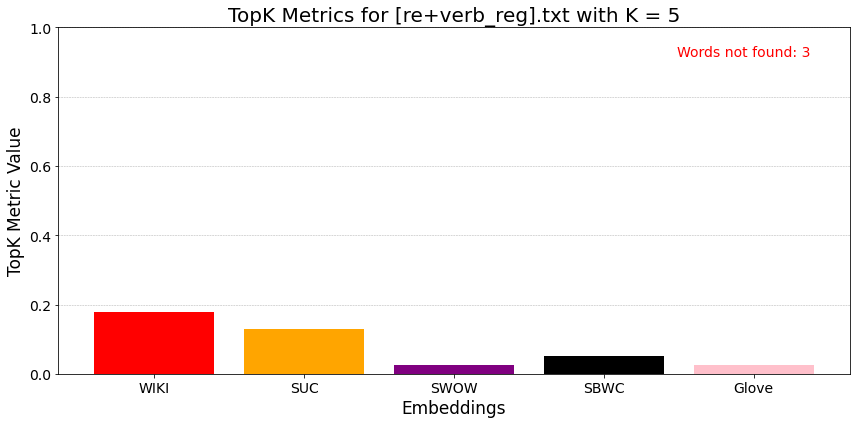

Plotting results for [un+adj_reg].txt


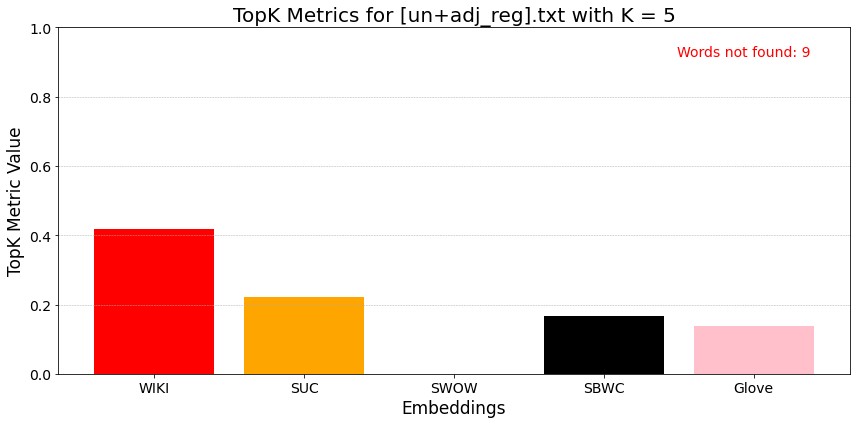

Plotting results for [verb+able_reg].txt


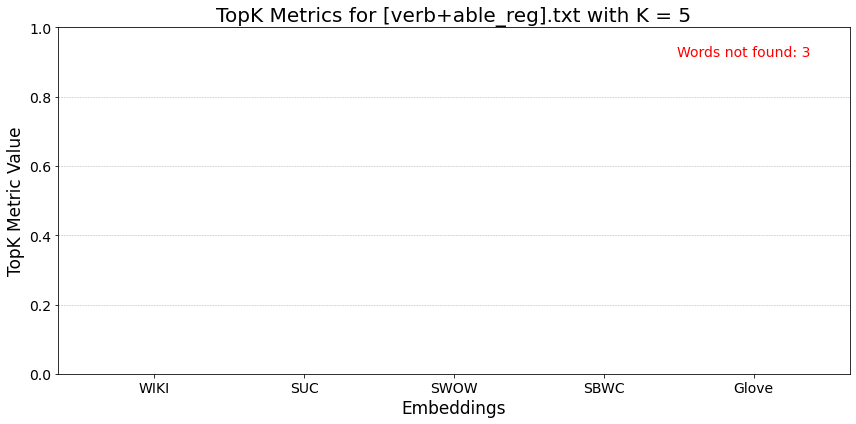

Plotting results for [verb+er_irreg_femenino].txt


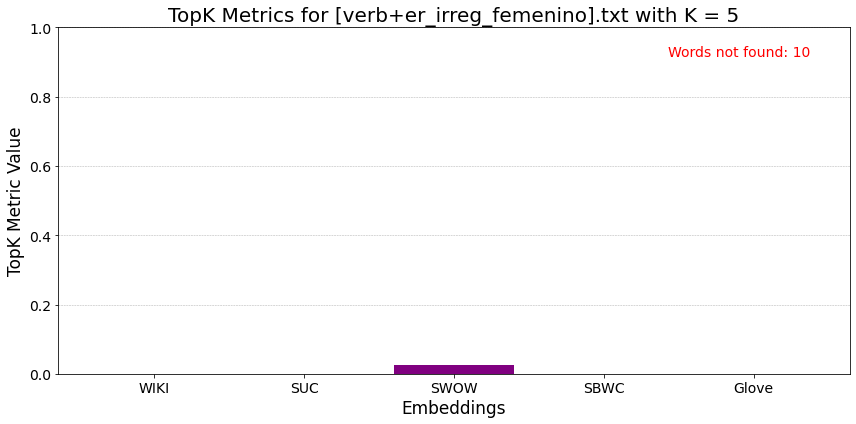

Plotting results for [verb+er_irreg_masculino].txt


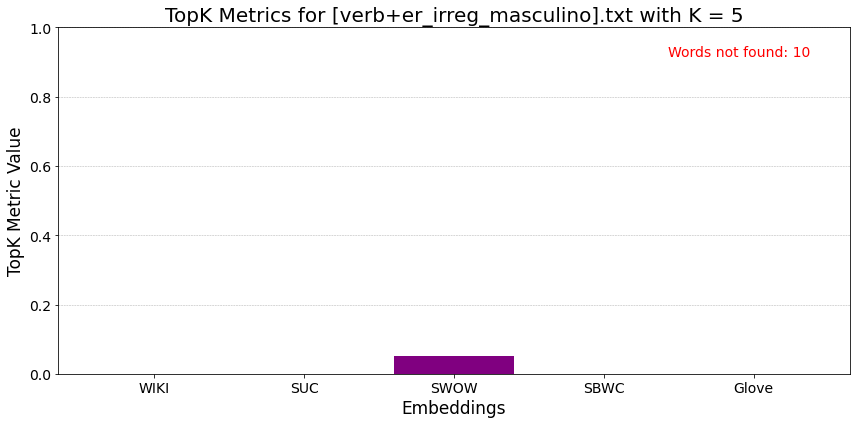

Plotting results for [verb+ment_irreg].txt


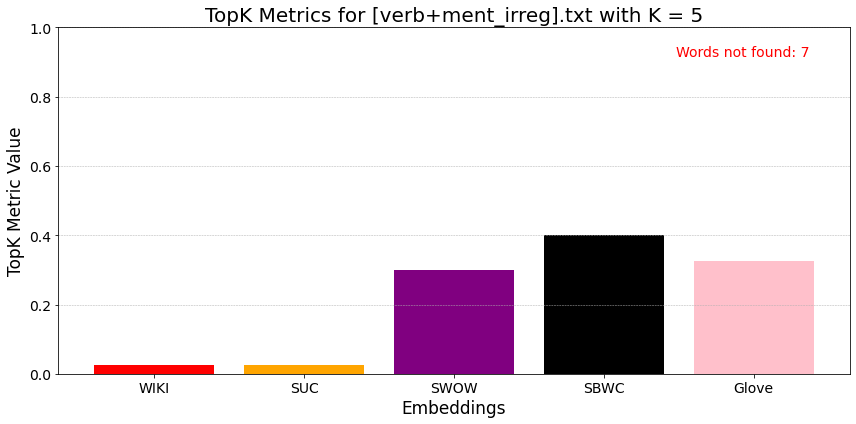

Plotting results for [verb+tion_irreg].txt


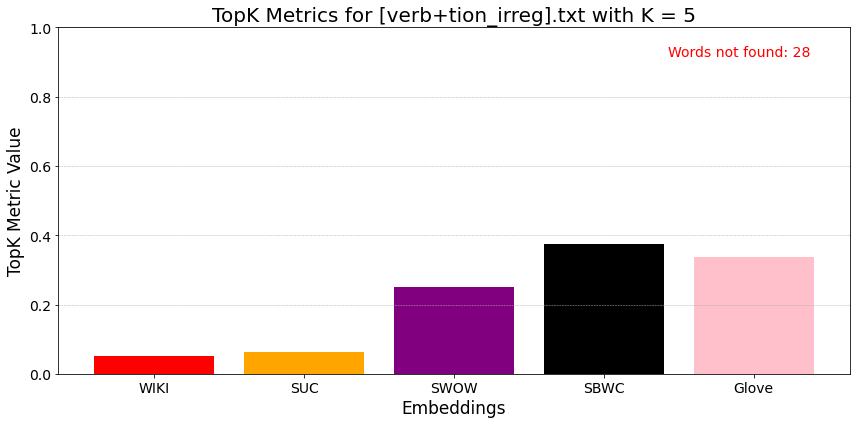

In [37]:
# Embedding names
embedding_names = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# Colors for plotting
colors = ['red', 'orange', 'purple', 'black', 'pink']

# Plot the results stored in metrics_results
for file_name, topK_metrics in metrics_results.items():
    print(f'Plotting results for {file_name}')

    # Flatten the list of lists
    topK_metrics_flat = [metric[0] for metric in topK_metrics]

    # Create the plot for the fixed K value data
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the top-K metrics
    x = np.arange(len(embedding_names))        
    ax.bar(x, topK_metrics_flat, color=colors)

    # Labels and titles
    ax.set_xlabel('Embeddings', fontsize=17)
    ax.set_ylabel('TopK Metric Value', fontsize=17)
    ax.set_title(f'TopK Metrics for {file_name} with K = {fixed_K}', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(embedding_names, fontsize=14)

    # Limit the y-axis between 0 and 1
    ax.set_ylim([0, 1])

    # Add the count of not found words
    not_found_words_count = len(not_found_words_by_file[file_name])
    ax.text(0.95, 0.95, f'Words not found: {not_found_words_count}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,
            color='red', fontsize=14)

    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()

### Encyclopedic_semantics

In [38]:
# Folder where the encyclopedic_semantics subfolder is located
encyclopedic_folder = os.path.join(bats_folder, 'encyclopedic_semantics')

# Load the files from the encyclopedic_semantics folder as DataFrames
dfs_encyclopedic_semantics = load_files(encyclopedic_folder)

Reading file: data\bats\encyclopedic_semantics\[animal - shelter].txt
Reading file: data\bats\encyclopedic_semantics\[animal - sound].txt
Reading file: data\bats\encyclopedic_semantics\[animal - young].txt
Reading file: data\bats\encyclopedic_semantics\[country - capital].txt
Reading file: data\bats\encyclopedic_semantics\[country - language].txt
Reading file: data\bats\encyclopedic_semantics\[male - female].txt
Reading file: data\bats\encyclopedic_semantics\[name - nationality].txt
Reading file: data\bats\encyclopedic_semantics\[name - occupation].txt
Reading file: data\bats\encyclopedic_semantics\[things - color].txt


In [39]:
# Function to calculate predictions
def calculate_encyclopedic_predictions(embedding, df, fixed_K):
    encyclopedic_predictions = []
    not_found_words_encyclopedic = []
    for index, row in df.iterrows():
        cue = row['cue']
        try:
            result = embedding.most_similar(positive=[cue], topn=fixed_K)
            if result:
                encyclopedic_predictions.append([word for word, _ in result])
            else:
                encyclopedic_predictions.append([])
        except KeyError as e:
            print(f"One of the words is not in the embedding: {cue} - {e}")
            encyclopedic_predictions.append([])
            not_found_words_encyclopedic.append(cue)
        except Exception as e:
            print(f"Error processing the word '{cue}' at index {index}: {e}")
            encyclopedic_predictions.append([])
    return encyclopedic_predictions, not_found_words_encyclopedic

# Function to calculate top-K metrics
def calculate_topK_encyclopedic_metrics(encyclopedic_predictions, df, K):
    df['response'] = df['response'].fillna('').apply(lambda x: str(x).lower())
    topK_encyclopedic_metrics = []
    for i, prediction in enumerate(encyclopedic_predictions):
        human_response = df.iloc[i]['response']
        if prediction:
            topK_encyclopedic_metrics.append(int(human_response in prediction[0:K]))
        else:
            topK_encyclopedic_metrics.append(0)
    return np.mean(topK_encyclopedic_metrics)

fixed_K_encyclopedic = 5
#Ks_encyclopedic = [5, 10, 15, 20, 25]

# Dictionary to store the calculated metrics
encyclopedic_metrics_results = {}
not_found_words_by_file_encyclopedic = {}

# Iterate over each file in dfs_encyclopedic_semantics
for file_name_encyclopedic, df_encyclopedic in dfs_encyclopedic_semantics.items():
    print(f'Analyzing file: {file_name_encyclopedic}')
    print(df_encyclopedic.head())  # Display the first rows of the DataFrame to check its content
    all_encyclopedic_predictions = []
    global_not_found_words_encyclopedic = []
    for embedding in embeddings_list:
        encyclopedic_predictions, not_found_words_encyclopedic = calculate_encyclopedic_predictions(embedding, df_encyclopedic, fixed_K_encyclopedic)
        all_encyclopedic_predictions.append(encyclopedic_predictions)
        global_not_found_words_encyclopedic.extend(not_found_words_encyclopedic)
    
    topK_encyclopedic_metrics = [[calculate_topK_encyclopedic_metrics(prediction, df_encyclopedic, fixed_K_encyclopedic)] for prediction in all_encyclopedic_predictions]
    
    encyclopedic_metrics_results[file_name_encyclopedic] = topK_encyclopedic_metrics
    not_found_words_by_file_encyclopedic[file_name_encyclopedic] = global_not_found_words_encyclopedic
    print(f"Top-K metrics for {file_name_encyclopedic} with K = {fixed_K_encyclopedic}: {topK_encyclopedic_metrics}")
    print(f"Words not found in {file_name_encyclopedic}: {global_not_found_words_encyclopedic}")

Analyzing file: [animal - shelter].txt
          cue    response
0     hormiga  hormiguero
1       simio    arboleda
2     babuino    arboleda
3  murciélago       cueva
4         oso     guarida
One of the words is not in the embedding: babuino - "Key 'babuino' not present in vocabulary"
One of the words is not in the embedding: chinchilla - "Key 'chinchilla' not present in vocabulary"
One of the words is not in the embedding: hámster - "Key 'hámster' not present in vocabulary"
One of the words is not in the embedding: marmota - "Key 'marmota' not present in vocabulary"
Top-K metrics for [animal - shelter].txt with K = 5: [[0.022727272727272728], [0.022727272727272728], [0.045454545454545456], [0.0], [0.0]]
Words not found in [animal - shelter].txt: ['babuino', 'chinchilla', 'hámster', 'marmota']
Analyzing file: [animal - sound].txt
          cue  response
0      alpaca   rebuzno
1         oso   gruñido
2       abeja   zumbido
3  escarabajo   zumbido
4        gato  maullido
One of the 

Plotting results for [animal - shelter].txt


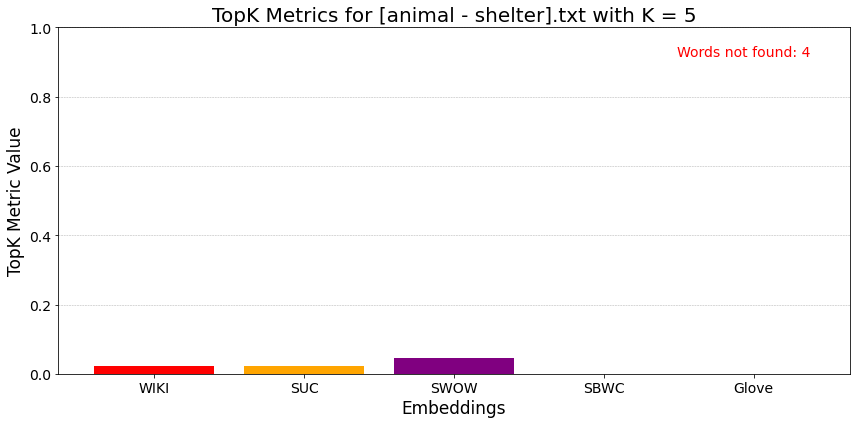

Plotting results for [animal - sound].txt


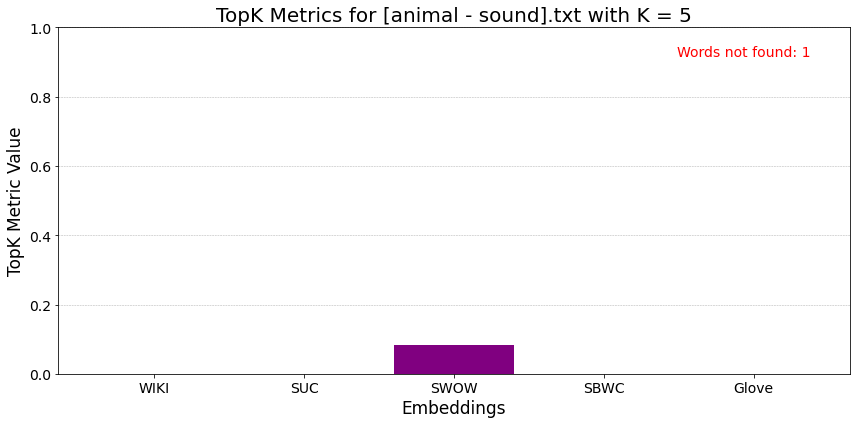

Plotting results for [animal - young].txt


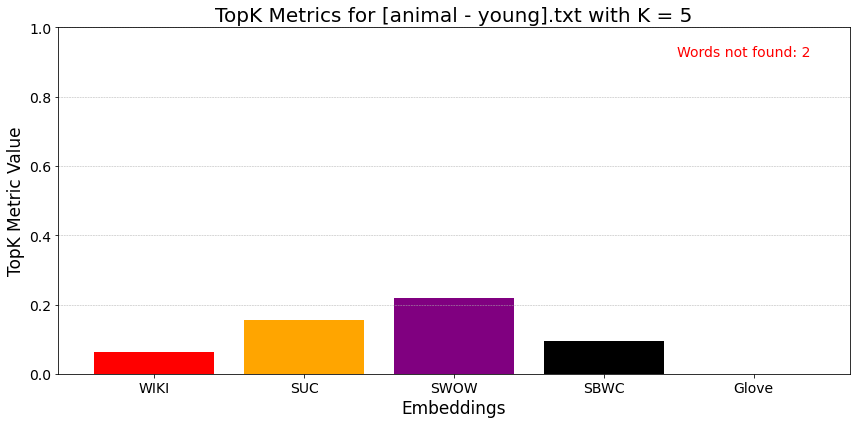

Plotting results for [country - capital].txt


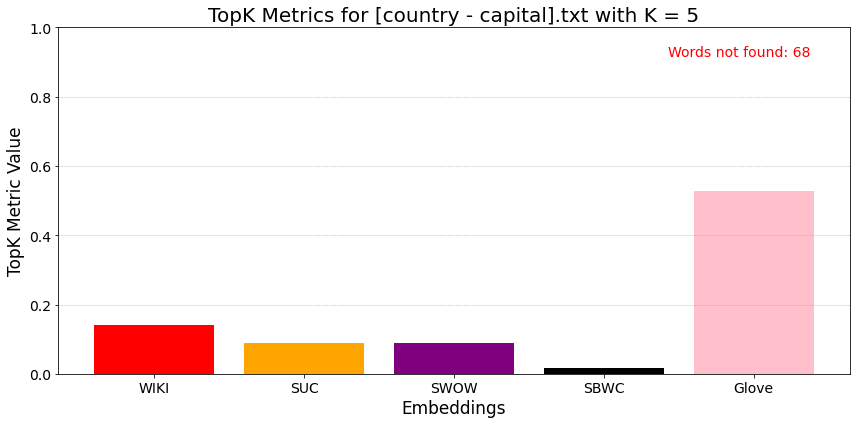

Plotting results for [country - language].txt


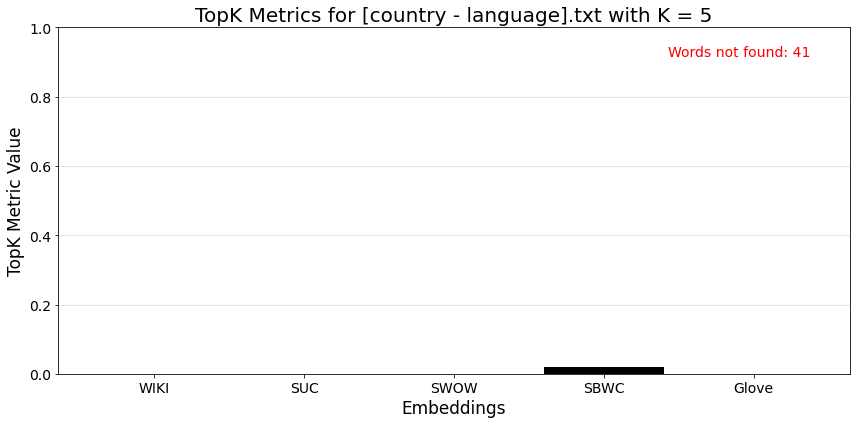

Plotting results for [male - female].txt


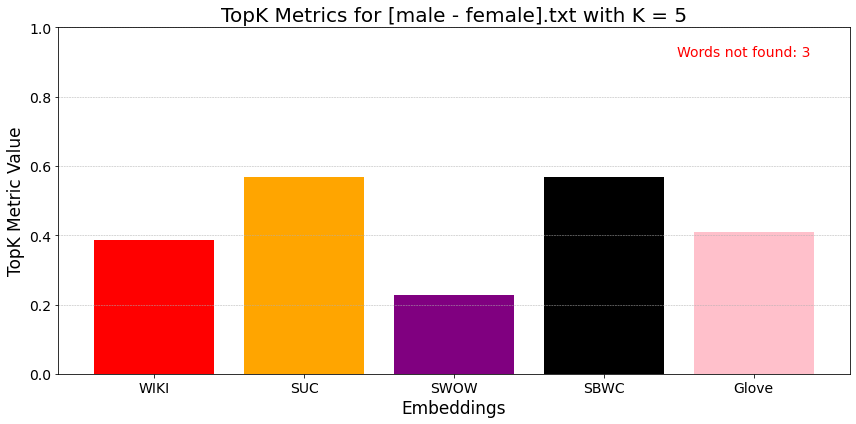

Plotting results for [name - nationality].txt


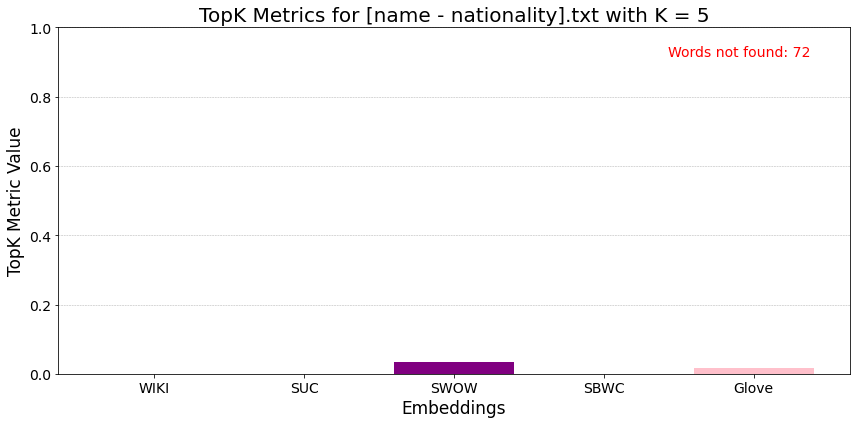

Plotting results for [name - occupation].txt


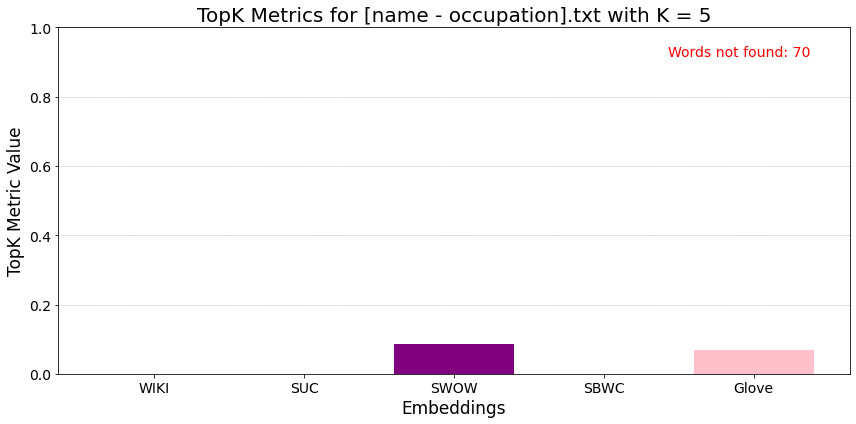

Plotting results for [things - color].txt


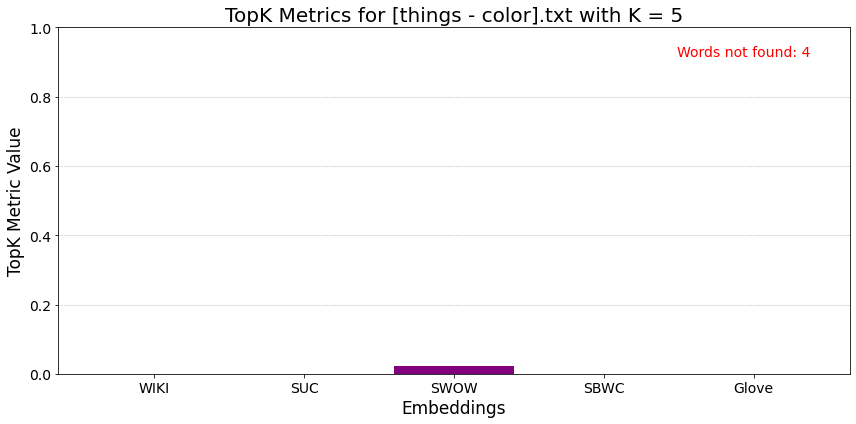

In [40]:
# Embedding names
embedding_names = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# Colors for plotting
colors = ['red', 'orange', 'purple', 'black', 'pink']

# Plot the results stored in encyclopedic_metrics_results
for file_name_encyclopedic, topK_metrics_encyclopedic in encyclopedic_metrics_results.items():
    print(f'Plotting results for {file_name_encyclopedic}')

    # Flatten the list of lists
    topK_metrics_encyclopedic_flat = [metric[0] for metric in topK_metrics_encyclopedic]

    # Create the plot for the fixed K value data
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the top-K metrics
    x = np.arange(len(embedding_names))        
    ax.bar(x, topK_metrics_encyclopedic_flat, color=colors)

    # Labels and titles
    ax.set_xlabel('Embeddings', fontsize=17)
    ax.set_ylabel('TopK Metric Value', fontsize=17)
    ax.set_title(f'TopK Metrics for {file_name_encyclopedic} with K = {fixed_K_encyclopedic}', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(embedding_names, fontsize=14)

    # Limit the y-axis between 0 and 1
    ax.set_ylim([0, 1])

    # Add the count of not found words
    not_found_words_count_encyclopedic = len(not_found_words_by_file_encyclopedic[file_name_encyclopedic])
    ax.text(0.95, 0.95, f'Words not found: {not_found_words_count_encyclopedic}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,
            color='red', fontsize=14)

    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()

### Inflectional_morphology

In [41]:
# Folder where the inflectional_morphology subfolder is located
inflectional_folder = os.path.join(bats_folder, 'inflectional_morphology')

# Load the files from the inflectional_morphology folder as DataFrames
dfs_inflectional_morphology = load_files(inflectional_folder)

Reading file: data\bats\inflectional_morphology\[adj - superlativo_femenino].txt
Reading file: data\bats\inflectional_morphology\[adj - superlativo_masculino].txt
Reading file: data\bats\inflectional_morphology\[sing_plural_reg_irreg].txt
Reading file: data\bats\inflectional_morphology\[verb-inf - Ving].txt
Reading file: data\bats\inflectional_morphology\[verb_inf - Ved].txt
Reading file: data\bats\inflectional_morphology\[verb_inf - Ving].txt
Reading file: data\bats\inflectional_morphology\[verb_inf -3pSg].txt
Reading file: data\bats\inflectional_morphology\[verb_Ving - Ved].txt


In [43]:
# Function to calculate predictions
def calculate_inflectional_predictions(embedding, df, fixed_K):
    inflectional_predictions = []
    not_found_words_inflectional = []
    for index, row in df.iterrows():
        cue = row['cue']
        try:
            result = embedding.most_similar(positive=[cue], topn=fixed_K)
            if result:
                inflectional_predictions.append([word for word, _ in result])
            else:
                inflectional_predictions.append([])
        except KeyError as e:
            print(f"One of the words is not in the embedding: {cue} - {e}")
            inflectional_predictions.append([])
            not_found_words_inflectional.append(cue)
        except Exception as e:
            print(f"Error processing the word '{cue}' at index {index}: {e}")
            inflectional_predictions.append([])
    return inflectional_predictions, not_found_words_inflectional

# Function to calculate top-K metrics
def topK_metrics_inflectional(predictions, df, K):
    df['response'] = df['response'].fillna('').apply(lambda x: str(x).lower())
    metrics = []
    for i, prediction in enumerate(predictions):
        human_response = df.iloc[i]['response']
        if prediction:
            metrics.append(int(human_response in prediction[0:K]))
        else:
            metrics.append(0)
    return np.mean(metrics)

fixed_K_inflectional = 5
#Ks_inflectional = [5, 10, 15, 20, 25]

# Dictionary to store the calculated metrics
inflectional_metrics_results = {}
not_found_words_by_file_inflectional = {}

# Iterate over each file in dfs_inflectional_morphology
for file_name_inflectional, df_inflectional in dfs_inflectional_morphology.items():
    print(f'Analyzing file: {file_name_inflectional}')
    print(df_inflectional.head())  # Display the first rows of the DataFrame to check its content
    all_inflectional_predictions = []
    global_not_found_words_inflectional = []
    for embedding in embeddings_list:
        inflectional_predictions, not_found_words_inflectional = calculate_inflectional_predictions(embedding, df_inflectional, fixed_K_inflectional)
        all_inflectional_predictions.append(inflectional_predictions)
        global_not_found_words_inflectional.extend(not_found_words_inflectional)
    
    inflectional_metrics = [[topK_metrics_inflectional(prediction, df_inflectional, fixed_K_inflectional)] for prediction in all_inflectional_predictions]
    
    inflectional_metrics_results[file_name_inflectional] = inflectional_metrics
    not_found_words_by_file_inflectional[file_name_inflectional] = global_not_found_words_inflectional
    print(f"Top-K metrics for {file_name_inflectional} with K = {fixed_K_inflectional}: {inflectional_metrics}")
    print(f"Words not found in {file_name_inflectional}: {global_not_found_words_inflectional}")

Analyzing file: [adj - superlativo_femenino].txt
           cue         response
0      enojada      enojadísima
1       barata       baratísima
2  inteligente  inteligentísima
3       rápida       rapidísima
4        lenta        lentísima
One of the words is not in the embedding: jodida - "Key 'jodida' not present in vocabulary"
One of the words is not in the embedding: perezosa - "Key 'perezosa' not present in vocabulary"
One of the words is not in the embedding: afortunada - "Key 'afortunada' not present in vocabulary"
One of the words is not in the embedding: arriesgada - "Key 'arriesgada' not present in vocabulary"
Top-K metrics for [adj - superlativo_femenino].txt with K = 5: [[0.15384615384615385], [0.34615384615384615], [0.0], [0.17307692307692307], [0.0]]
Words not found in [adj - superlativo_femenino].txt: ['jodida', 'perezosa', 'afortunada', 'arriesgada']
Analyzing file: [adj - superlativo_masculino].txt
           cue         response
0      enojado      enojadísimo
1     

Plotting results for [adj - superlativo_femenino].txt


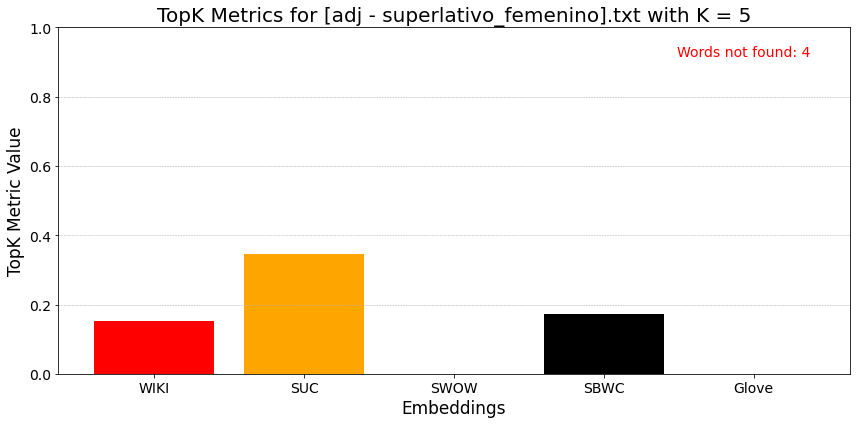

Plotting results for [adj - superlativo_masculino].txt


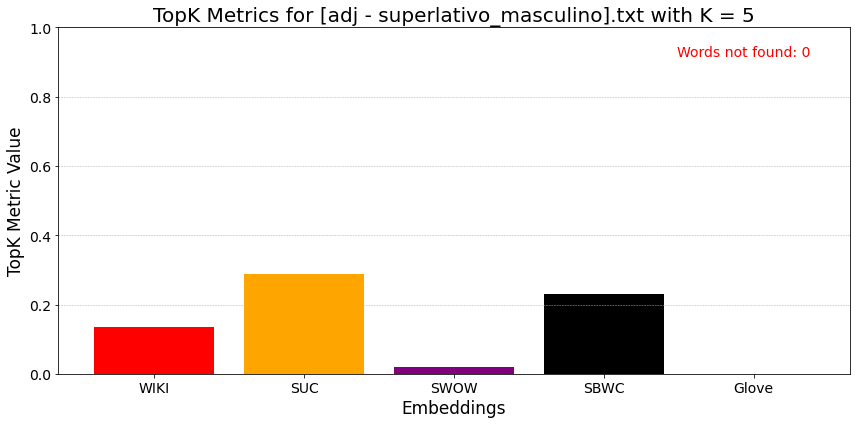

Plotting results for [sing_plural_reg_irreg].txt


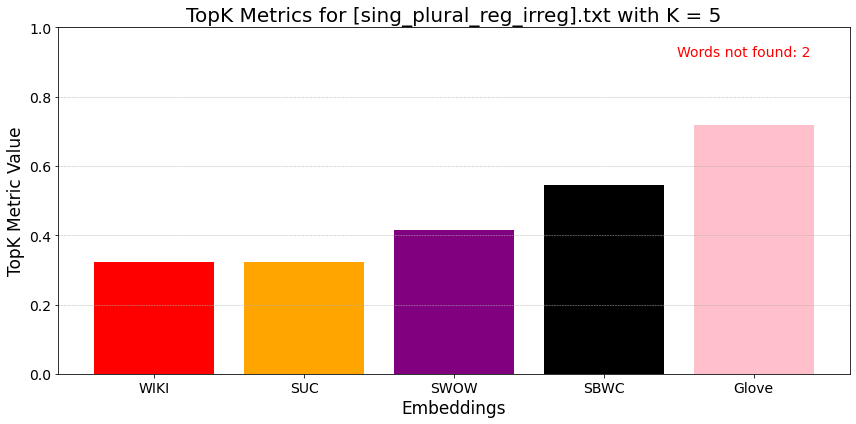

Plotting results for [verb-inf - Ving].txt


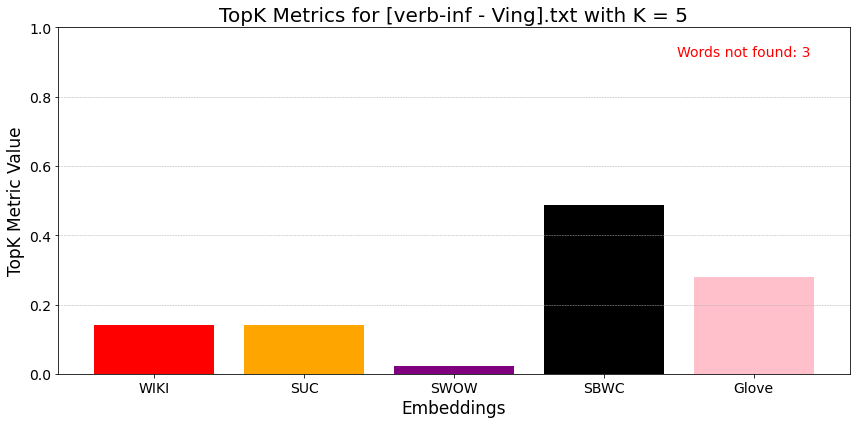

Plotting results for [verb_inf - Ved].txt


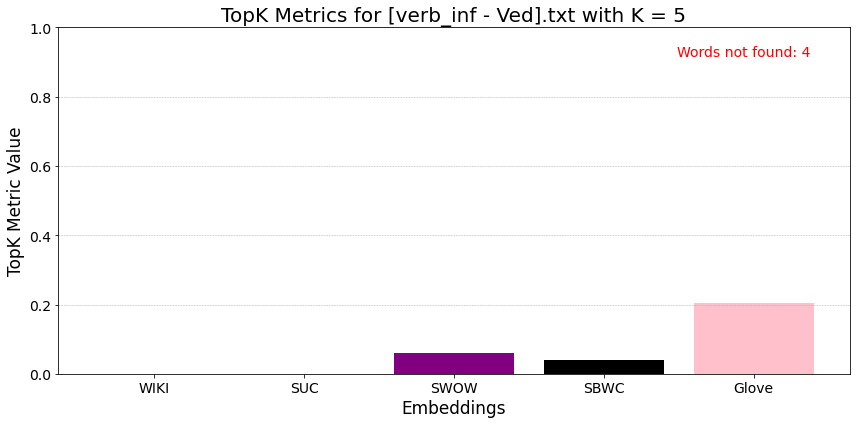

Plotting results for [verb_inf - Ving].txt


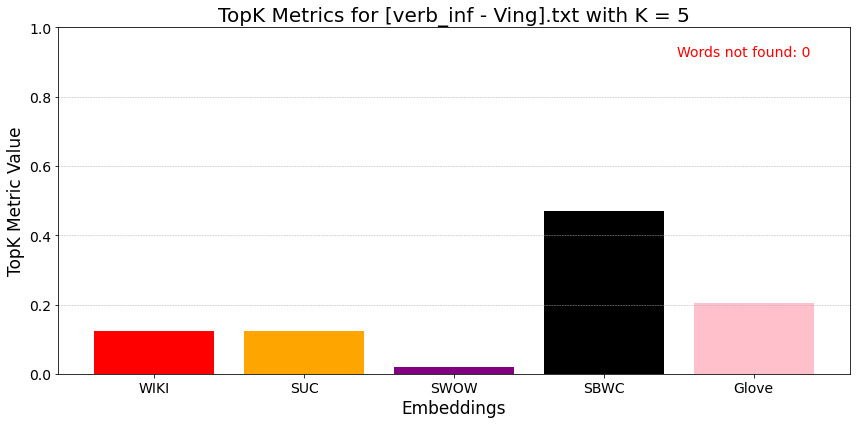

Plotting results for [verb_inf -3pSg].txt


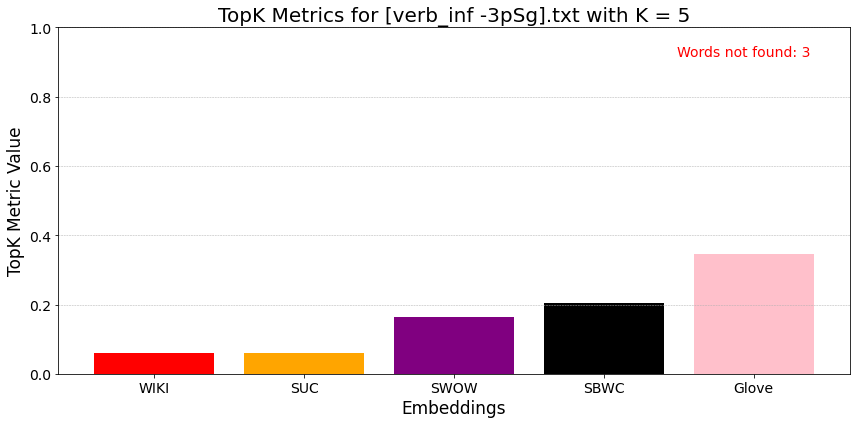

Plotting results for [verb_Ving - Ved].txt


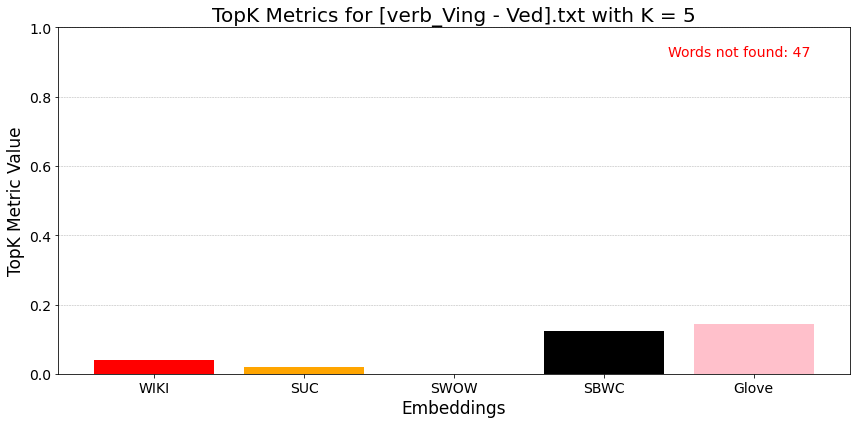

In [44]:
# Embedding names
embedding_names = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# Colors for plotting
colors = ['red', 'orange', 'purple', 'black', 'pink']

# Plot the results stored in inflectional_metrics_results
for file_name_inflectional, inflectional_metrics in inflectional_metrics_results.items():
    print(f'Plotting results for {file_name_inflectional}')

    # Flatten the list of lists
    inflectional_metrics_flat = [metric[0] for metric in inflectional_metrics]

    # Create the plot for the fixed K value data
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the top-K metrics
    x = np.arange(len(embedding_names))        
    ax.bar(x, inflectional_metrics_flat, color=colors)

    # Labels and titles
    ax.set_xlabel('Embeddings', fontsize=17)
    ax.set_ylabel('TopK Metric Value', fontsize=17)
    ax.set_title(f'TopK Metrics for {file_name_inflectional} with K = {fixed_K_inflectional}', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(embedding_names, fontsize=14)

    # Limit the y-axis between 0 and 1
    ax.set_ylim([0, 1])

    # Add the count of not found words
    not_found_words_count_inflectional = len(not_found_words_by_file_inflectional[file_name_inflectional])
    ax.text(0.95, 0.95, f'Words not found: {not_found_words_count_inflectional}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,
            color='red', fontsize=14)

    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()

### Lexicographic_semantics

In [45]:
# Folder where the lexicographic_semantics subfolder is located
lexicographic_folder = os.path.join(bats_folder, 'lexicographic_semantics')

# Load the files from the lexicographic_semantics folder as DataFrames
dfs_lexicographic_semantics = load_files(lexicographic_folder)

Reading file: data\bats\lexicographic_semantics\[hiperonimos - animales].txt
Reading file: data\bats\lexicographic_semantics\[hiperonimos - miscelanea].txt
Reading file: data\bats\lexicographic_semantics\[meronimos - sustancia].txt
Reading file: data\bats\lexicographic_semantics\[sinonimos - exact].txt


In [46]:
# Function to calculate predictions
def calculate_lexicographic_predictions(embedding, df, fixed_K):
    lexicographic_predictions = []
    not_found_words_lexicographic = []
    for index, row in df.iterrows():
        cue = row['cue']
        try:
            result = embedding.most_similar(positive=[cue], topn=fixed_K)
            if result:
                lexicographic_predictions.append([word for word, _ in result])
            else:
                lexicographic_predictions.append([])
        except KeyError as e:
            print(f"One of the words is not in the embedding: {cue} - {e}")
            lexicographic_predictions.append([])
            not_found_words_lexicographic.append(cue)
        except Exception as e:
            print(f"Error processing the word '{cue}' at index {index}: {e}")
            lexicographic_predictions.append([])
    return lexicographic_predictions, not_found_words_lexicographic

# Function to calculate top-K metrics
def topK_metrics_lexicographic(predictions, df, K):
    df['response'] = df['response'].fillna('').apply(lambda x: str(x).lower())
    metrics = []
    for i, prediction in enumerate(predictions):
        human_response = df.iloc[i]['response']
        if prediction:
            metrics.append(int(human_response in prediction[0:K]))
        else:
            metrics.append(0)
    return np.mean(metrics)

fixed_K_lexicographic = 5
#Ks_lexicographic = [5, 10, 15, 20, 25]

# Dictionary to store the calculated metrics
lexicographic_metrics_results = {}
not_found_words_by_file_lexicographic = {}

# Iterate over each file in dfs_lexicographic_semantics
for file_name_lexicographic, df_lexicographic in dfs_lexicographic_semantics.items():
    print(f'Analyzing file: {file_name_lexicographic}')
    print(df_lexicographic.head())  # Display the first rows of the DataFrame to check its content
    all_lexicographic_predictions = []
    global_not_found_words_lexicographic = []
    for embedding in embeddings_list:
        lexicographic_predictions, not_found_words_lexicographic = calculate_lexicographic_predictions(embedding, df_lexicographic, fixed_K_lexicographic)
        all_lexicographic_predictions.append(lexicographic_predictions)
        global_not_found_words_lexicographic.extend(not_found_words_lexicographic)
    
    lexicographic_metrics = [[topK_metrics_lexicographic(prediction, df_lexicographic, fixed_K_lexicographic)] for prediction in all_lexicographic_predictions]
    
    lexicographic_metrics_results[file_name_lexicographic] = lexicographic_metrics
    not_found_words_by_file_lexicographic[file_name_lexicographic] = global_not_found_words_lexicographic
    print(f"Top-K metrics for {file_name_lexicographic} with K = {fixed_K_lexicographic}: {lexicographic_metrics}")
    print(f"Words not found in {file_name_lexicographic}: {global_not_found_words_lexicographic}")

Analyzing file: [hiperonimos - animales].txt
          cue response
0    anaconda   víbora
1     hormiga  insecto
2      castor   roedor
3       abeja  insecto
4  escarabajo  insecto
One of the words is not in the embedding: chinchilla - "Key 'chinchilla' not present in vocabulary"
One of the words is not in the embedding: jaguar - "Key 'jaguar' not present in vocabulary"
One of the words is not in the embedding: velociraptor - "Key 'velociraptor' not present in vocabulary"
One of the words is not in the embedding: triceratops - "Key 'triceratops' not present in vocabulary"
One of the words is not in the embedding: tiranosaurio - "Key 'tiranosaurio' not present in vocabulary"
One of the words is not in the embedding: ñandú - "Key 'ñandú' not present in vocabulary"
Top-K metrics for [hiperonimos - animales].txt with K = 5: [[0.0], [0.07894736842105263], [0.47368421052631576], [0.02631578947368421], [0.02631578947368421]]
Words not found in [hiperonimos - animales].txt: ['chinchilla', 'j

Plotting results for [hiperonimos - animales].txt


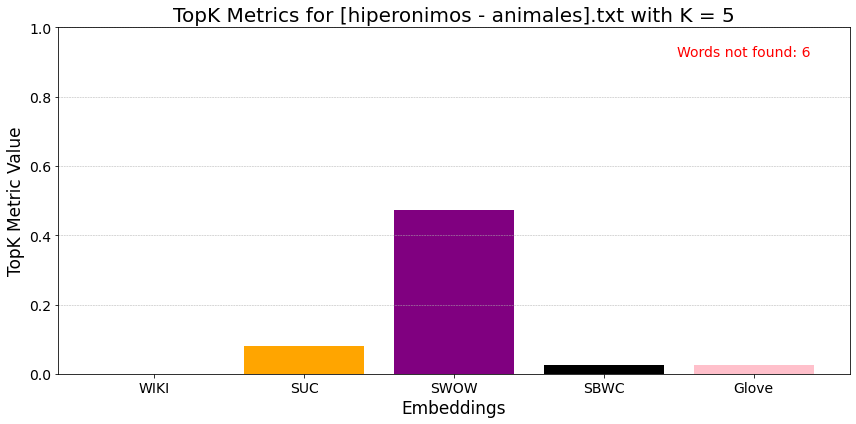

Plotting results for [hiperonimos - miscelanea].txt


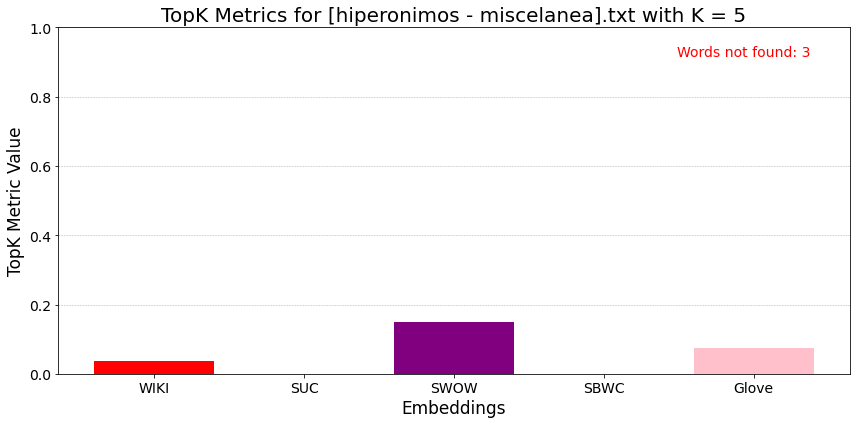

Plotting results for [meronimos - sustancia].txt


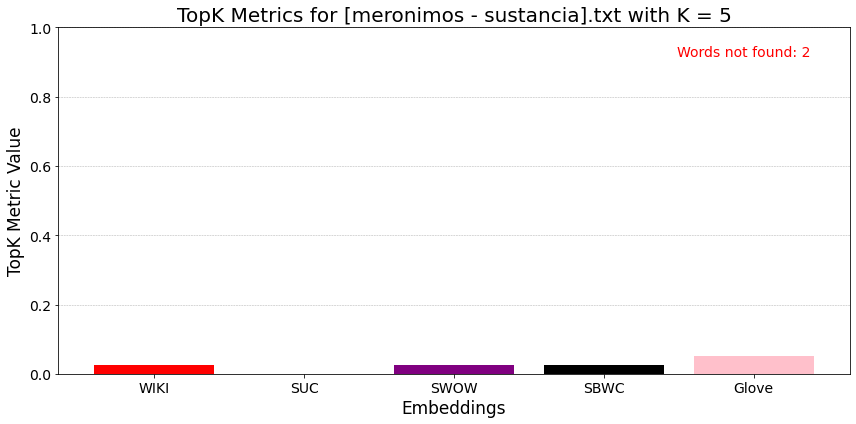

Plotting results for [sinonimos - exact].txt


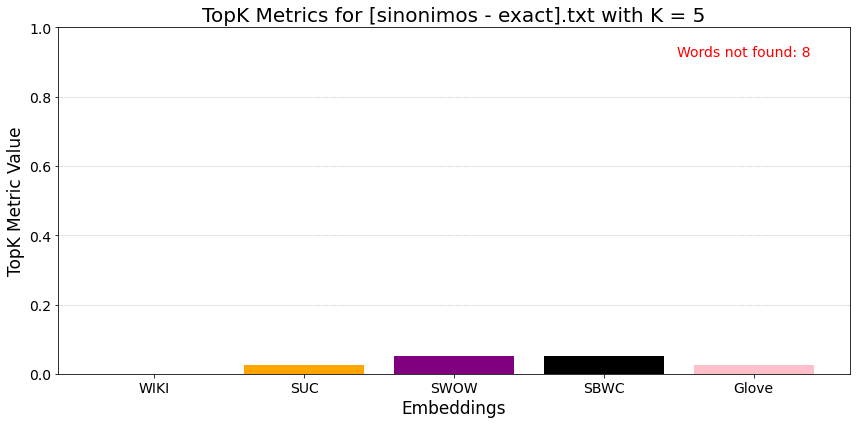

In [47]:
# Embedding names
embedding_names = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# Colors for plotting
colors = ['red', 'orange', 'purple', 'black', 'pink']

# Plot the results stored in lexicographic_metrics_results
for file_name_lexicographic, topK_metrics_lexicographic in lexicographic_metrics_results.items():
    print(f'Plotting results for {file_name_lexicographic}')

    # Flatten the list of lists
    topK_metrics_lexicographic_flat = [metric[0] for metric in topK_metrics_lexicographic]

    # Create the plot for the fixed K value data
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the top-K metrics
    x = np.arange(len(embedding_names))        
    ax.bar(x, topK_metrics_lexicographic_flat, color=colors)

    # Labels and titles
    ax.set_xlabel('Embeddings', fontsize=17)
    ax.set_ylabel('TopK Metric Value', fontsize=17)
    ax.set_title(f'TopK Metrics for {file_name_lexicographic} with K = {fixed_K_lexicographic}', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(embedding_names, fontsize=14)

    # Limit the y-axis between 0 and 1
    ax.set_ylim([0, 1])

    # Add the count of not found words
    not_found_words_count_lexicographic = len(not_found_words_by_file_lexicographic[file_name_lexicographic])
    ax.text(0.95, 0.95, f'Words not found: {not_found_words_count_lexicographic}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,
            color='red', fontsize=14)

    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()

### BATS results

### Derivational Morphology

[re+verb_reg] embeddings_WIKI en primer lugar, seguido por embeddings_SUC en segundo lugar. SWOW quedó en cuarto lugar.

[un+adj_reg] embeddings_WIKI en primer lugar, seguido por embeddings_SUC en segundo lugar. SWOW no logró ninguna predicción correcta.

[verb+able_reg] ningún embedding logró predicciones correctas.

[verb+er_irreg_femenino] Solo SWOW tuvo predicciones correctas, los otros embeddings no.

[verb+er_irreg_masculino] Solo SWOW tuvo predicciones correctas, los otros embeddings no.

[verb+ment_irreg] SWOW en primer lugar, seguido por embeddings_SBWC en segundo lugar.

[verb+tion_irreg] SWOW en primer lugar, seguido de cerca por embeddings_SBWC en segundo lugar.

### Encyclopedic Semantics

[animal - shelter] Solo SWOW tuvo predicciones correctas, los otros embeddings no.

[animal - sound] SWOW fue el único embedding que logró predicciones correctas.

[animal - young] SWOW tuvo un rendimiento en primer lugar, seguido por embeddings_SUC en segundo lugar.

[country - capital] embeddings_Glove tuvo un rendimiento en primer lugar, seguido por embeddings_WIKI en segundo lugar. SWOW quedó en cuarto lugar.

[country - language] embeddings_SBWC tuvo un rendimiento en primer lugar. SWOW no logró ninguna predicción correcta.

[male - female] embeddings_SUC y embeddings_SBWC lideran en primer lugar. SWOW quedó en cuarto lugar.

[name - nationality] SWOW quedó en primer lugar, seguido por Glove, el resto no tuvo predicciones correctas. 

[name - occupation] SWOW quedó en primer lugar, seguido por Glove, el resto no tuvo predicciones correctas. 

### Inflectional Morphology

[adj - superlativo_femenino] embeddings_SUC en primer lugar, seguido por embeddings_WIKI en segundo lugar. SWOW quedó en tercer lugar.

[adj - superlativo_masculino] embeddings_SUC en primer lugar, seguido por embeddings_WIKI en segundo lugar. SWOW quedó en tercer lugar.

[sing_plural_reg_irreg] embeddings_SBWC en primer lugar, seguido por embeddings_SUC en segundo lugar. SWOW no logró predicciones correctas.

[verb-inf - Ving] embeddings_SBWC en primer lugar, seguido por embeddings_WIKI en segundo lugar. SWOW quedó en cuarto lugar.

[verb_inf - Ved] embeddings_SBWC en primer lugar, seguido por embeddings_WIKI en segundo lugar. SWOW no logró predicciones correctas.

[verb_inf - Ving] embeddings_SBWC en primer lugar, seguido por embeddings_WIKI en segundo lugar. SWOW quedó en cuarto lugar.

[verb_inf -3pSg] embeddings_SBWC en primer lugar, seguido por embeddings_WIKI en segundo lugar. SWOW quedó en quinto lugar.

[verb_Ving - Ved] embeddings_SBWC en primer lugar, seguido por embeddings_WIKI en segundo lugar. SWOW quedó en cuarto lugar.


### Lexicographic Semantics

[hiperonimos - animales] embeddings_SBWC en primer lugar, seguido por embeddings_SUC en segundo lugar. SWOW quedó en tercer lugar.

[hiperonimos - miscelanea] embeddings_SBWC en primer lugar, seguido por embeddings_SUC en segundo lugar. SWOW quedó en quinto lugar.

[meronimos - sustancia] embeddings_SBWC en primer lugar, seguido por embeddings_WIKI en segundo lugar. SWOW quedó en tercer lugar.

[sinonimos - exact] embeddings_WIKI en primer lugar, seguido por embeddings_SUC en segundo lugar. SWOW quedó en tercer lugar.